In [2]:
import os
from math import sqrt

from pyod.models.knn import KNN

import pandas as pd
from pandas.api.types import is_string_dtype

import numpy as np

import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from matplotlib import pyplot as plt

In [3]:
def tratar_dataset(dataset):
    
    for coluna in dataset.columns:
        if is_string_dtype(dataset[coluna]):
            dataset[coluna] = dataset[coluna].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
            dataset[coluna] = dataset[coluna].str.upper()
            
    dataset.columns = map(str.upper, dataset.columns)
    
    return dataset


def localizar_modelo(dataset, lista_estados, dicionario):
    for estado in lista_estados:
        df_modelo_uf = dataset.query('UF == @estado')[["LEADS", "COD_MODELO_VEICULO"]].groupby(by=["COD_MODELO_VEICULO"]).sum().sort_values(by="LEADS", ascending=False).head()
        
        dicionario["UF"].append(estado)

        for indice, (modelo, lead) in enumerate(df_modelo_uf.iterrows()):
            dicionario[f"TOP {indice + 1}"].append([modelo, lead.LEADS])

    return pd.DataFrame(dicionario)
    

def localizar_marca(dataset, lista_estados, dicionario):
    for estado in lista_estados:
        df_marca_uf = dataset.query('UF == @estado')[["LEADS", "COD_MARCA_VEICULO"]].groupby(by=["COD_MARCA_VEICULO"]).sum().sort_values(by="LEADS", ascending=False).head()
        
        dicionario["UF"].append(estado)

        for indice, (marca, lead) in enumerate(df_marca_uf.iterrows()):
            dicionario[f"TOP {indice + 1}"].append([marca, lead.LEADS])

    return pd.DataFrame(dicionario)

In [4]:
pd.options.display.max_columns = None

In [5]:
dataset = pd.read_csv("../datasets/Case 1 - dados.csv", sep=",")

In [63]:
len(dataset)

48661

In [66]:
len(dataset.drop_duplicates())

48661

Verificação caso há algum valor duplicado no dataset para ser removido, porém como o tamanho não foi alterado, não foi removida nenhuma linha.

In [6]:
tratar_dataset(dataset)

,COD_ANUNCIO,COD_CLIENTE,COD_TIPO_PESSOA,PRIORIDADE,LEADS,VIEWS,CLIQUES_TELEFONE*,COD_MARCA_VEICULO,COD_MODELO_VEICULO,COD_VERSAO_VEICULO,ANO_MODELO,CEP_2DIG,UF_CIDADE,VLR_ANUNCIO,QTD_FOTOS,KM_VEICULO,VLR_MERCADO,FLG_UNICO_DONO,FLG_LICENCIADO,FLG_IPVA_PAGO,FLG_TODAS_REVISOES_CONCESSIONARIA,FLG_TODAS_REVISOES_AGENDA_VEICULO,FLG_GARANTIA_FABRICA,FLG_BLINDADO,FLG_ACEITA_TROCA,FLG_ADAPTADO_PCD,COMBUSTIVEL,CAMBIO,PORTAS,ALARME,AIRBAG,ARQUENTE,BANCOCOURO,ARCONDIC,ABS,DESEMBTRAS,TRAVAELETR,VIDROSELETR,RODASLIGA,SENSORCHUVA,SENSORESTACION
0,2,7941,2,3,1,0,0,34,769,346932,2018,75,GO_ITUMBIARA,110990.00,7,0,NaN,0,0,0.0,0.0,0,0.0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,1770,1,3,1,0,4,2,704,340148,1996,6,SP_OSASCO,8300.00,0,689815,NaN,0,0,0.0,0.0,0,0.0,0,0,0.0,ALCOOL,MANUAL,2.0,S,NaN,S,N,N,S,N,S,S,N,N,N
2,8,709,1,3,4,0,11,30,1071,310713,2002,2,SP_SAO PAULO,38800.00,4,33700,NaN,0,0,0.0,0.0,0,0.0,0,0,0.0,GASOLINA,MANUAL,4.0,S,NaN,S,N,S,S,S,S,S,S,N,N
3,13,9708,1,2,12,0,14,10,2028,341195,1995,4,SP_SAO PAULO,44000.00,8,105000,NaN,0,1,1.0,0.0,0,0.0,0,0,0.0,GASOLINA,AUTOMATICO,2.0,N,S,S,S,S,N,N,S,S,S,N,N
4,15,1363,1,2,8,0,11,12,805,332063,1995,5,SP_SAO PAULO,30000.00,6,71240,NaN,0,0,0.0,0.0,0,0.0,0,0,0.0,GASOLINA,AUTOMATICO,4.0,S,N,S,S,S,S,S,S,S,S,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48660,195918,3065,2,3,1,34184,0,280,3365,346359,2016,17,SP_JAAO,48000.00,8,35000,48011.33387,0,0,NaN,NaN,0,NaN,0,0,NaN,GASOLINA,MANUAL,4.0,S,S,S,S,S,S,S,S,S,S,N,S
48661,195924,12535,2,3,1,45048,0,4,1177,343882,2013,25,RJ_DUQUE DE CAXIAS,42999.99,1,91222,43085.32550,0,0,NaN,NaN,0,NaN,0,0,NaN,GASOLINA E ALCOOL,MANUAL,4.0,N,N,N,N,N,N,N,N,N,N,N,N
48662,195930,2284,2,3,1,71020,0,5,3128,344252,2012,13,SP_JUNDIAA,93900.00,0,120000,81696.56707,0,0,NaN,NaN,0,NaN,0,0,NaN,DIESEL,AUTOMATICO,4.0,N,N,N,N,N,N,N,N,N,N,N,N
48663,195934,2284,2,3,0,82940,0,2,3323,344421,2014,13,SP_JUNDIAA,53800.00,0,40000,45804.01330,0,0,NaN,NaN,0,NaN,0,0,NaN,GASOLINA E ALCOOL,AUTOMATICO,4.0,S,N,S,N,S,N,S,S,S,S,N,N


In [6]:
dataset.isna().sum()

COD_ANUNCIO                             0
COD_CLIENTE                             0
COD_TIPO_PESSOA                         0
PRIORIDADE                              0
LEADS                                   0
VIEWS                                   0
CLIQUES_TELEFONE*                       0
COD_MARCA_VEICULO                       0
COD_MODELO_VEICULO                      0
COD_VERSAO_VEICULO                      0
ANO_MODELO                              0
CEP_2DIG                                0
UF_CIDADE                               0
VLR_ANUNCIO                             0
QTD_FOTOS                               0
KM_VEICULO                              0
VLR_MERCADO                          6217
FLG_UNICO_DONO                          0
FLG_LICENCIADO                          0
FLG_IPVA_PAGO                         312
FLG_TODAS_REVISOES_CONCESSIONARIA     312
FLG_TODAS_REVISOES_AGENDA_VEICULO       0
FLG_GARANTIA_FABRICA                  312
FLG_BLINDADO                      

Verificação da presença de valores Nan e assim quando for para colunas numéricas é feita a substituição pela mediana, e valores categóricos são tratados a seguir.

In [7]:
dataset.fillna(dataset.median(), inplace=True)

C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11016\556827914.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset.fillna(dataset.median(), inplace=True)


In [8]:
dataset[["UF", "CIDADE"]] = dataset["UF_CIDADE"].str.split("_", expand=True)

Realizando a separação entre UF e CIDADE, para tratar separadamente cada coluna e principalmente utilizar a coluna UF.

In [31]:
dataset["UF"].value_counts()

SP     22918
PR      4440
SC      3760
RJ      3717
MG      3243
RS      2609
DF      1758
GO       931
PE       771
BA       632
MS       553
RN       530
CE       524
ES       472
MT       409
PB       236
MA       232
PA       181
RO       164
AM       158
PI       146
SE       119
AL        80
AC        32
AP        18
RR        15
TO        13
N/A        4
Name: UF, dtype: int64

In [9]:
dataset = dataset[dataset["UF"] != "N/A"]

In [10]:
dataset_modelo = dataset[["LEADS", "COD_MODELO_VEICULO"]].groupby(by=["COD_MODELO_VEICULO"]).sum()

In [11]:
dataset_marca = dataset[["LEADS", "COD_MARCA_VEICULO"]].groupby(by=["COD_MARCA_VEICULO"]).sum()

In [11]:
dataset_marca.sort_values(by="LEADS", ascending=False).head()

,LEADS
COD_MARCA_VEICULO,
5,27213
2,26911
16,20706
4,19798
3,18537


c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

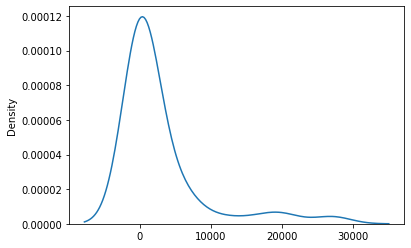

In [89]:
sns.distplot(x=dataset_marca["LEADS"], hist=False)

O gráfico acima demonstra que poucas marcas possuem a maior parte dos leads e que muitas marcas possuem poucos leads.

In [12]:
dataset_modelo.sort_values(by="LEADS", ascending=False).head()

,LEADS
COD_MODELO_VEICULO,
690,7982
1194,5927
776,5410
740,4533
687,4509


c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

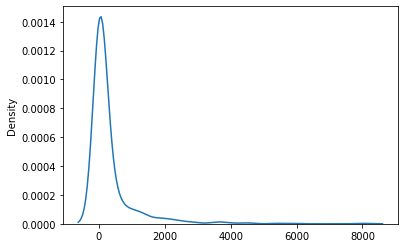

In [90]:
sns.distplot(x=dataset_modelo["LEADS"], hist=False)

Assim como mostrado acima, o gráfico superior demonstra que poucos modelos possuem a maior parte dos leads e que muitos modelos possuem poucos leads.

In [10]:
dataset_uf = dataset[["LEADS", "UF"]].groupby(by=["UF"]).sum()

In [14]:
dataset_uf.sort_values(by="LEADS", ascending=False).head()

,LEADS
UF,
SP,151382
RJ,15177
MG,9973
PR,9638
SC,6609


In [11]:
dataset_cidade = dataset[["LEADS", "CIDADE"]].groupby(by=["CIDADE"]).sum()

In [17]:
dataset_cidade.sort_values(by="LEADS", ascending=False).head()

,LEADS
CIDADE,
SAO PAULO,88765
RIO DE JANEIRO,11020
CAMPINAS,7407
BELO HORIZONTE,5721
SAO BERNARDO DO CAMPO,5248


In [12]:
df_modelo = {"UF": [],
    "TOP 1": [],
    "TOP 2": [],
    "TOP 3": [],
    "TOP 4": [],
    "TOP 5": [],
    }

df_marca = {"UF": [],
    "TOP 1": [],
    "TOP 2": [],
    "TOP 3": [],
    "TOP 4": [],
    "TOP 5": [],
    }

lista_estados = ["SP", "RJ", "MG", "PR", "SC"]

df_modelo = localizar_modelo(dataset, lista_estados, df_modelo)
df_marca = localizar_marca(dataset, lista_estados, df_marca)

In [70]:
df_marca

,UF,TOP 1,TOP 2,TOP 3,TOP 4,TOP 5
0,SP,"[2, 19208]","[5, 19130]","[16, 16102]","[3, 13592]","[17, 12302]"
1,RJ,"[4, 1893]","[16, 1718]","[5, 1520]","[2, 1213]","[3, 1107]"
2,MG,"[4, 1400]","[5, 1371]","[2, 1039]","[3, 700]","[16, 553]"
3,PR,"[2, 1552]","[5, 1304]","[4, 1085]","[16, 887]","[3, 592]"
4,SC,"[5, 1011]","[2, 992]","[4, 721]","[3, 580]","[30, 401]"


In [23]:
df_modelo

,UF,TOP 1,TOP 2,TOP 3,TOP 4,TOP 5
0,SP,"[690, 5892]","[1194, 5019]","[776, 4077]","[687, 3473]","[1222, 2834]"
1,RJ,"[690, 656]","[740, 617]","[2848, 450]","[1194, 367]","[1193, 327]"
2,MG,"[740, 380]","[1057, 271]","[761, 261]","[690, 237]","[788, 232]"
3,PR,"[690, 551]","[761, 418]","[776, 258]","[788, 256]","[740, 170]"
4,SC,"[788, 209]","[690, 202]","[740, 166]","[763, 164]","[687, 162]"


In [13]:
dataset["APRESENTA_LEAD"] = np.where(dataset["LEADS"] > 0, 1, 0)

C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11016\3360614176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["APRESENTA_LEAD"] = np.where(dataset["LEADS"] > 0, 1, 0)


Realizando a criação da coluna de APRESENTA_LEAD, para assim no modelo de classificação podermos separar quem recebeu lead e quem não.

In [14]:
encoder = LabelEncoder()

dataset["UF"] = encoder.fit_transform(dataset["UF"])
dataset["RODASLIGA"] = encoder.fit_transform(dataset["RODASLIGA"])
dataset["ARCONDIC"] = encoder.fit_transform(dataset["ARCONDIC"])
dataset["CAMBIO"] = encoder.fit_transform(dataset["CAMBIO"])

C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11016\3188084872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["UF"] = encoder.fit_transform(dataset["UF"])
C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11016\3188084872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["RODASLIGA"] = encoder.fit_transform(dataset["RODASLIGA"])
C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11016\3188084872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [128]:
max(dataset["COD_MODELO_VEICULO"].unique())

3695

Verificando o máximo valor da coluna de MODELO para que possa ser verificado se os dados necessitam de normalização.

In [15]:
dados_normalizados = dataset[["COD_MODELO_VEICULO", "COD_MARCA_VEICULO"]]
min_max_scaler = MinMaxScaler()
dados_normalizados = min_max_scaler.fit_transform(dados_normalizados)
df = pd.DataFrame(dados_normalizados)

In [16]:
dataset["COD_MODELO_VEICULO"], dataset["COD_MARCA_VEICULO"] = list(zip(*dados_normalizados))

C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11016\3619526513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["COD_MODELO_VEICULO"], dataset["COD_MARCA_VEICULO"] = list(zip(*dados_normalizados))


Realizando o teste com a biblioteca PyOD, que detecta outliers conforme o algoritmo inserido (no caso utilizamos KNN para aprendizado)

In [17]:
detector = KNN()

detector.fit(dataset.iloc[:, 1:4])

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [28]:
previsoes = detector.labels_
previsoes

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
outliers = dataset.loc[previsoes == 1]

In [31]:
outliers

,COD_ANUNCIO,COD_CLIENTE,COD_TIPO_PESSOA,PRIORIDADE,LEADS,VIEWS,CLIQUES_TELEFONE*,COD_MARCA_VEICULO,COD_MODELO_VEICULO,COD_VERSAO_VEICULO,ANO_MODELO,CEP_2DIG,UF_CIDADE,VLR_ANUNCIO,QTD_FOTOS,KM_VEICULO,VLR_MERCADO,FLG_UNICO_DONO,FLG_LICENCIADO,FLG_IPVA_PAGO,FLG_TODAS_REVISOES_CONCESSIONARIA,FLG_TODAS_REVISOES_AGENDA_VEICULO,FLG_GARANTIA_FABRICA,FLG_BLINDADO,FLG_ACEITA_TROCA,FLG_ADAPTADO_PCD,COMBUSTIVEL,CAMBIO,PORTAS,ALARME,AIRBAG,ARQUENTE,BANCOCOURO,ARCONDIC,ABS,DESEMBTRAS,TRAVAELETR,VIDROSELETR,RODASLIGA,SENSORCHUVA,SENSORESTACION,UF,CIDADE,APRESENTA_LEAD
10,32,233,1,2,0,0,12,0.012461,0.593074,339963,1977,4,SP_SAO PAULO,150000.0,8,5001,40668.754055,1,1,1.0,0.0,0,0.0,0,0,0.0,GASOLINA,5,2.0,N,N,N,S,0,N,N,N,N,1,N,N,25,SAO PAULO,0
12,43,15847,1,1,1,0,10,0.056075,0.703734,339076,2010,18,SP_IPERA3,62500.0,4,13500,33912.963060,1,1,1.0,0.0,0,1.0,0,1,0.0,GASOLINA,5,4.0,S,NaN,S,N,1,N,S,S,S,1,N,N,25,IPERA3,1
14,46,15488,1,1,1,0,12,0.320872,0.578193,322451,2000,14,SP_RIBEIRAO PRETO,43900.0,5,125000,40668.754055,0,1,1.0,0.0,0,0.0,1,0,0.0,GASOLINA,0,4.0,S,S,S,S,1,S,S,S,S,1,N,N,25,RIBEIRAO PRETO,1
15,51,13319,1,1,4,0,11,0.009346,0.334957,342509,2010,1,SP_SAO PAULO,19900.0,2,38000,40668.754055,1,1,1.0,0.0,1,0.0,0,1,0.0,GASOLINA E ALCOOL,5,4.0,S,N,S,N,0,N,N,S,S,0,N,N,25,SAO PAULO,1
16,55,15375,1,1,104,0,72,0.052960,0.186959,342914,2010,2,SP_SAO PAULO,38999.0,6,102000,39661.902120,1,1,1.0,0.0,0,1.0,0,1,0.0,GASOLINA E ALCOOL,0,4.0,S,N,S,S,1,S,S,S,S,1,N,N,25,SAO PAULO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48600,35096,14279,1,2,48,48,58,0.417445,0.605519,344183,2011,7,SP_GUARULHOS,69900.0,5,135000,40668.754055,0,1,1.0,0.0,0,0.0,0,0,0.0,DIESEL,5,2.0,N,N,S,N,1,N,N,S,S,0,N,N,25,GUARULHOS,1
48606,39231,32350,1,3,56,56,41,0.009346,0.309524,343632,2012,30,MG_BELO HORIZONTE,14000.0,7,119000,40668.754055,1,1,1.0,0.0,0,0.0,0,1,0.0,GASOLINA E ALCOOL,5,2.0,N,N,N,N,0,N,N,N,N,0,N,N,10,BELO HORIZONTE,1
48611,39761,14595,1,3,56,56,20,0.028037,0.177219,345546,2015,5,SP_SAO PAULO,75000.0,8,49350,92633.337770,0,1,1.0,1.0,1,1.0,0,1,0.0,GASOLINA,0,4.0,S,S,S,S,1,S,S,S,S,1,S,S,25,SAO PAULO,1
48621,195790,35932,1,3,1,10784,2,0.087227,0.648268,342715,2016,20,RJ_RIO DE JANEIRO,59000.0,8,63000,61711.793510,1,1,0.0,0.0,0,0.0,0,0,0.0,"GASOLINA, ALCOOL E GAS NATURAL",4,4.0,S,S,S,S,1,S,S,S,S,1,N,S,18,RIO DE JANEIRO,1


Com a variável outliers podemos então verificar a melhor opção a ser realizada, seja tratar esses outliers, remove-los do dataset, ou apenas mante-los no dataset.

In [33]:
np.unique(previsoes, return_counts=True)

(array([0, 1]), array([43968,  4693], dtype=int64))

Quantidade de outliers identificados com o detector, no caso de 43968 dados deste dataset, 4693 linhas são consideradas outliers, representando 10.67% dos dados gerais. 

In [19]:
X = dataset[["UF", "COD_MODELO_VEICULO", "COD_MARCA_VEICULO"]]
y = dataset["APRESENTA_LEAD"]

In [113]:
dataset["APRESENTA_LEAD"].value_counts()

1    38032
0    10629
Name: APRESENTA_LEAD, dtype: int64

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [113]:
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_train, y_train)
predicao = decision_tree.predict(X_test)

In [115]:
random_forest = RandomForestClassifier(random_state=1)
random_forest.fit(X_train, y_train)
predicao = random_forest.predict(X_test)

In [114]:
recall_decision = recall_score(y_test, predicao)
precisao_decision = precision_score(y_test, predicao)
f1_decision = f1_score(y_test, predicao)


In [116]:
recall_forest = recall_score(y_test, predicao)
precisao_forest = precision_score(y_test, predicao)
f1_forest = f1_score(y_test, predicao)


In [117]:
print(recall_decision, precisao_decision, f1_decision)

0.9606381587550673 0.7870995392692596 0.8652532391048292


In [ ]:
0.9606381587550673 0.7870995392692596 0.8652532391048292 0.7649234562827494


In [118]:
print(recall_forest, precisao_forest, f1_forest)

0.9748921145547274 0.7867243562684677 0.8707586287449629


In [ ]:
0.9748921145547274 0.7867243562684677 0.8707586287449629 0.7726291996301243


In [111]:
dataset["CLIQUES_TELEFONE*"].value_counts()

3      5362
2      5272
4      4808
1      4667
0      4227
       ... 
162       1
199       1
112       1
171       1
201       1
Name: CLIQUES_TELEFONE*, Length: 161, dtype: int64

In [83]:
dataset["CAMBIO"].value_counts()

MANUAL                   27009
AUTOMATICO               20864
CVT                        507
AUTOMATIZADO               134
SEMI-AUTOMATICO            124
AUTOMATICO SEQUENCIAL       11
AUTOMATIZADO DCT            11
Name: CAMBIO, dtype: int64

In [106]:
dataset["FLG_ADAPTADO_PCD"].value_counts()

0.0    48641
1.0       20
Name: FLG_ADAPTADO_PCD, dtype: int64

In [20]:
dataset = dataset.drop(["COD_ANUNCIO", "COD_CLIENTE", "COD_TIPO_PESSOA", "ANO_MODELO", "COD_VERSAO_VEICULO",
                        "CEP_2DIG", "QTD_FOTOS", "KM_VEICULO", "VLR_MERCADO", "FLG_GARANTIA_FABRICA",
                        "FLG_BLINDADO", "FLG_TODAS_REVISOES_AGENDA_VEICULO", "FLG_ADAPTADO_PCD"], axis=1)

<AxesSubplot:>

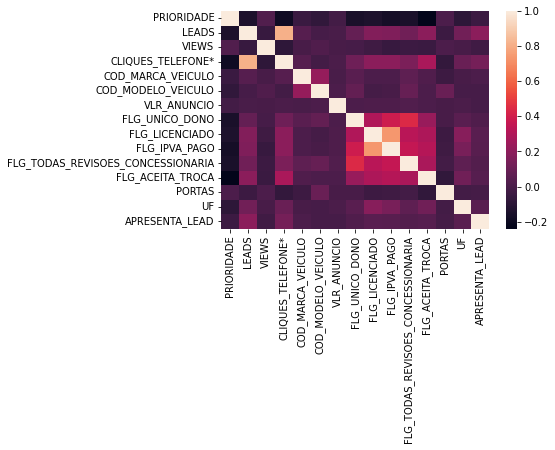

In [110]:
sns.heatmap(dataset.corr())

Observada a correlação entre as variáveis para identificar possíveis colunas que possam ser removidas e agregadas na análise do dataset.

Visto que principalmente a coluna "CLIQUES_TELEFONE*" tem uma alta correlação com "LEADS", ela será utilizada como variável do modelo selecionado.

In [21]:
X = dataset[["UF", "COD_MODELO_VEICULO", "COD_MARCA_VEICULO", "CLIQUES_TELEFONE*", "CAMBIO"]]
y = dataset["LEADS"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [23]:
decision_tree = DecisionTreeRegressor(random_state=1)
decision_tree.fit(X_train, y_train)
predicao = decision_tree.predict(X_test)

In [26]:
random_forest = RandomForestRegressor(random_state=1)
random_forest.fit(X_train, y_train)
predicao = random_forest.predict(X_test)

In [27]:
mae = mean_absolute_error(y_test, predicao)
mse = mean_squared_error(y_test, predicao)
rmse = sqrt(mse)


In [25]:
print(mae, mse, rmse)

3.9215837464784364 85.93905406416863 9.270331928478539


In [28]:
print(mae, mse, rmse)

3.357635674311444 57.54557393187909 7.58587990492066


In [133]:
dataset.LEADS.describe()

count    48661.000000
mean         4.416884
std         11.961681
min          0.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        364.000000
Name: LEADS, dtype: float64